# Project 13: Text Analysis
---

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## The Dataset

- The data is stored in the imdb_reviews.tsv file
- The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).
- Here's the description of the selected fields:
    - **review**: the review text.
    - **pos**: the target, '0' for negative and '1' for positive,
    - **ds_part**: 'train'/'test' for the train/test part of dataset, correspondingly.
- There are other fields in the dataset. They are unnecessary for the scope of the project but may be explored further.

## Imports

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Load and Preprocess Data

In [4]:
df = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
df.head(2)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


In [6]:
df.duplicated().sum()

0

In [7]:
# Only 2 nulls, therefor I can drop without much worry
df = df.dropna()

## EDA

#### Number of movies and reviews by year

In [8]:
df.head(2)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336


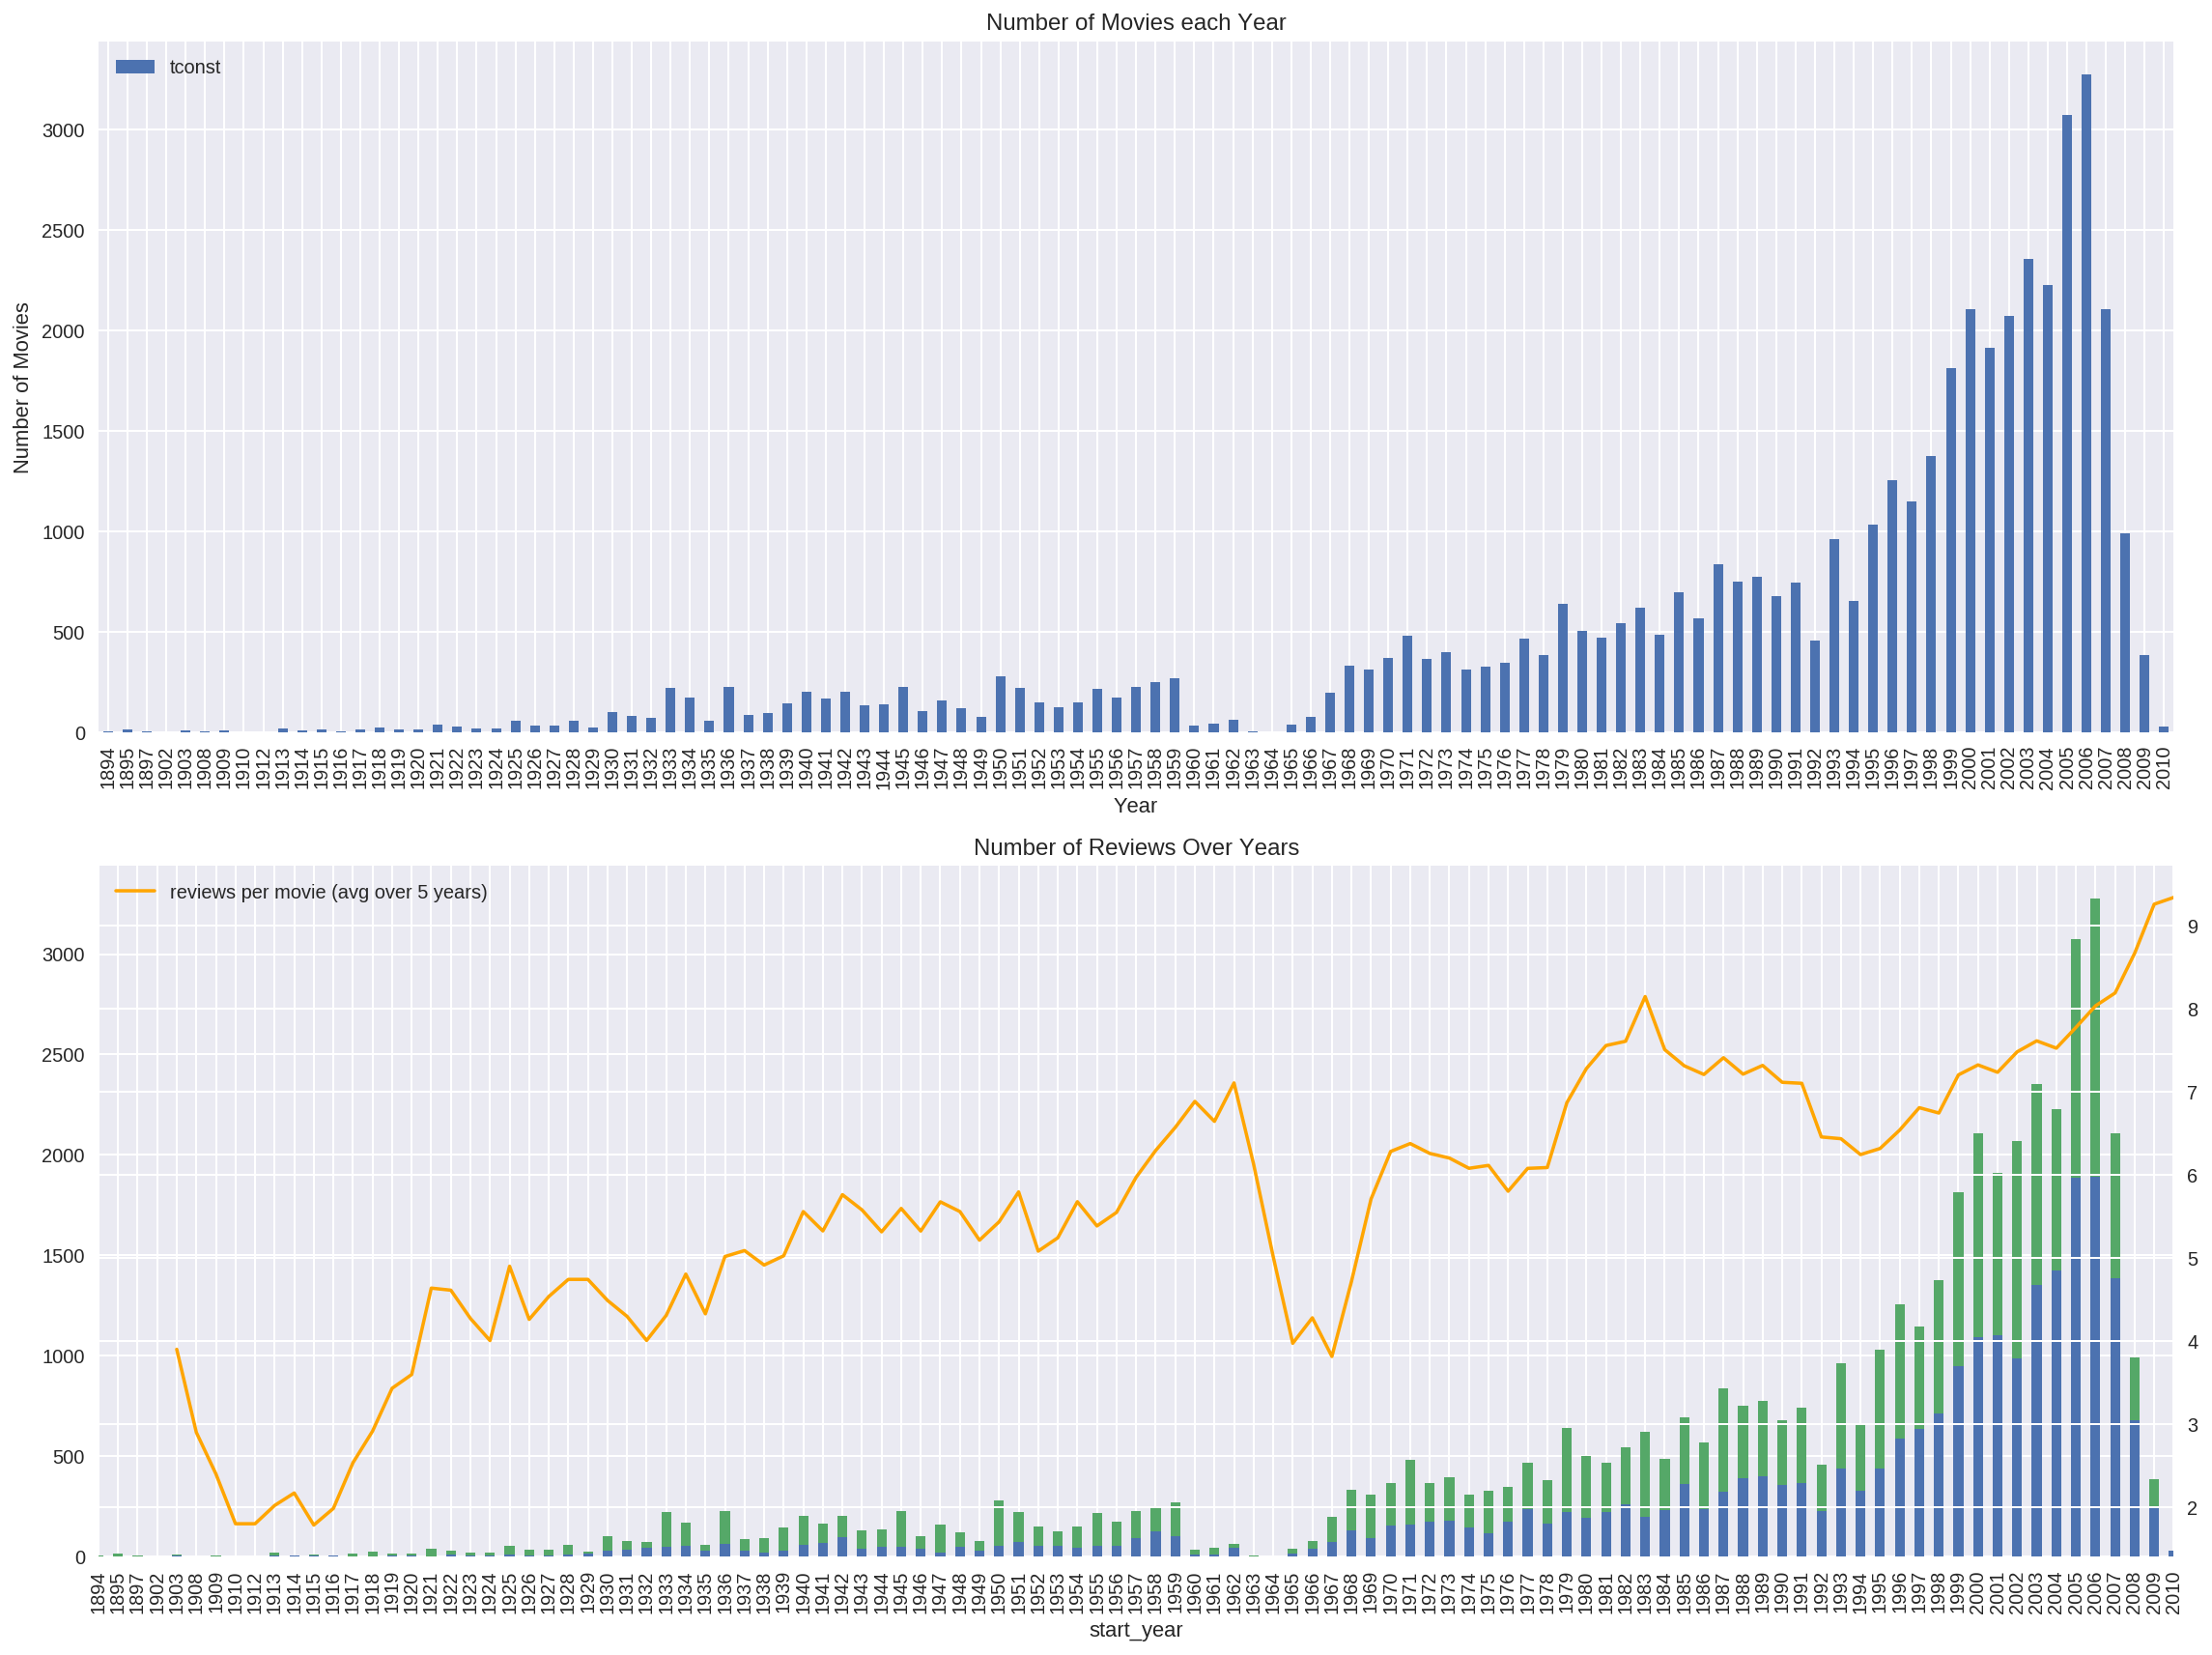

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 12))

# First Chart: Movies per year
ax = axs[0]

mov_per_year = pd.DataFrame(df.groupby('start_year')['tconst'].count())
mov_per_year.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies each Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Movies')

# Second Chart: Reviews per year, overlayed with average reviews per movie on the right axis
ax = axs[1]

pos_neg = df.groupby(['start_year', 'pos'])['pos'].count().unstack()
pos_neg.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

rev_per_movie = (df['start_year'].value_counts().sort_index().fillna(0)/df[['tconst', 'start_year']].drop_duplicates()
                 ['start_year'].value_counts().sort_index().fillna(0)).fillna(0)

axt = ax.twinx()
rev_per_movie.reset_index(drop=True).rolling(5).mean().plot(color='orange', 
                                                            label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

#### Comparing amount of positive and negative reviews

In [10]:
df['pos'].value_counts(normalize=True)

0    0.501067
1    0.498933
Name: pos, dtype: float64

- They are close enough to even in terms of numbers/proportions

#### Comparing positive and negative review distribution in the training and test data sets

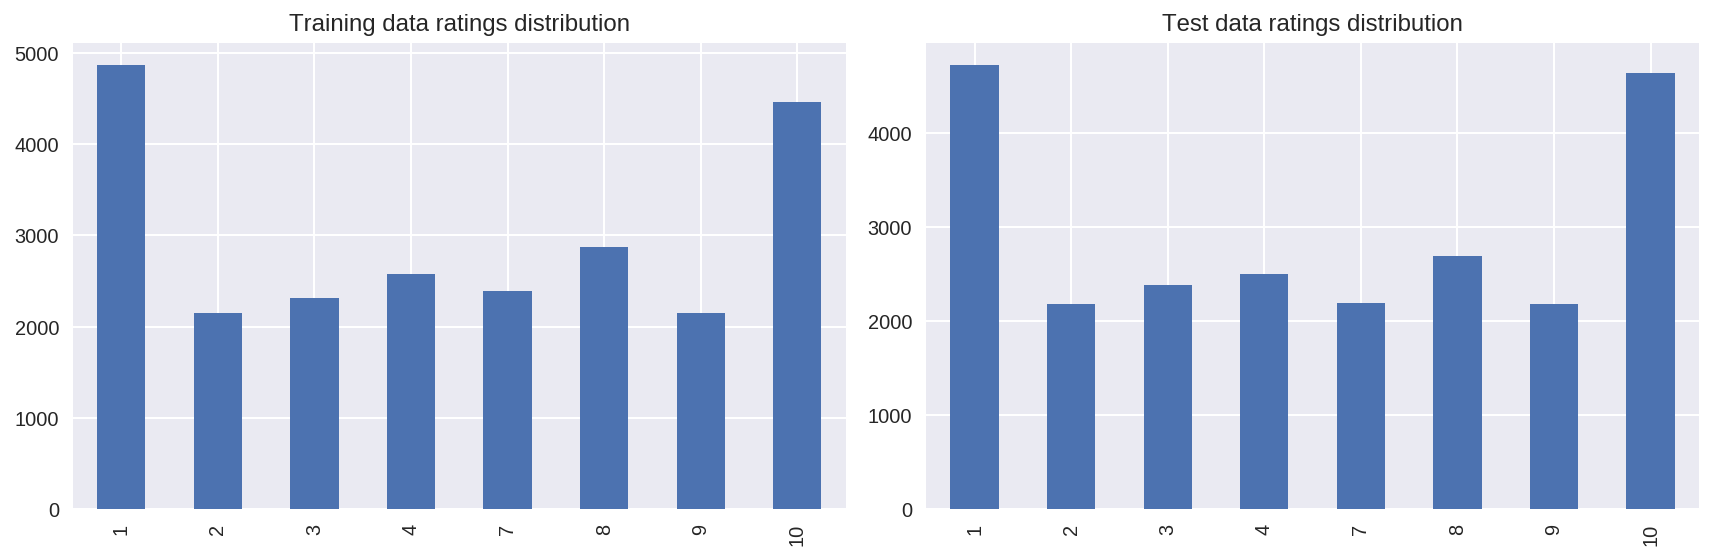

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
train = df[df['ds_part'] == 'train']
train_cnt = train['rating'].value_counts().sort_index()
train_cnt.plot.bar(ax=ax)
ax.set_title('Training data ratings distribution')

ax = axs[1]
test = df[df['ds_part'] == 'test']
test_cnt = test['rating'].value_counts().sort_index()
test_cnt.plot(kind='bar', ax=ax)
ax.set_title('Test data ratings distribution')

fig.tight_layout()

- Both the training and test dataset have very similar distributions in terms of ratings

#### Distribution of negative and positive reviews over the years for two parts of the dataset

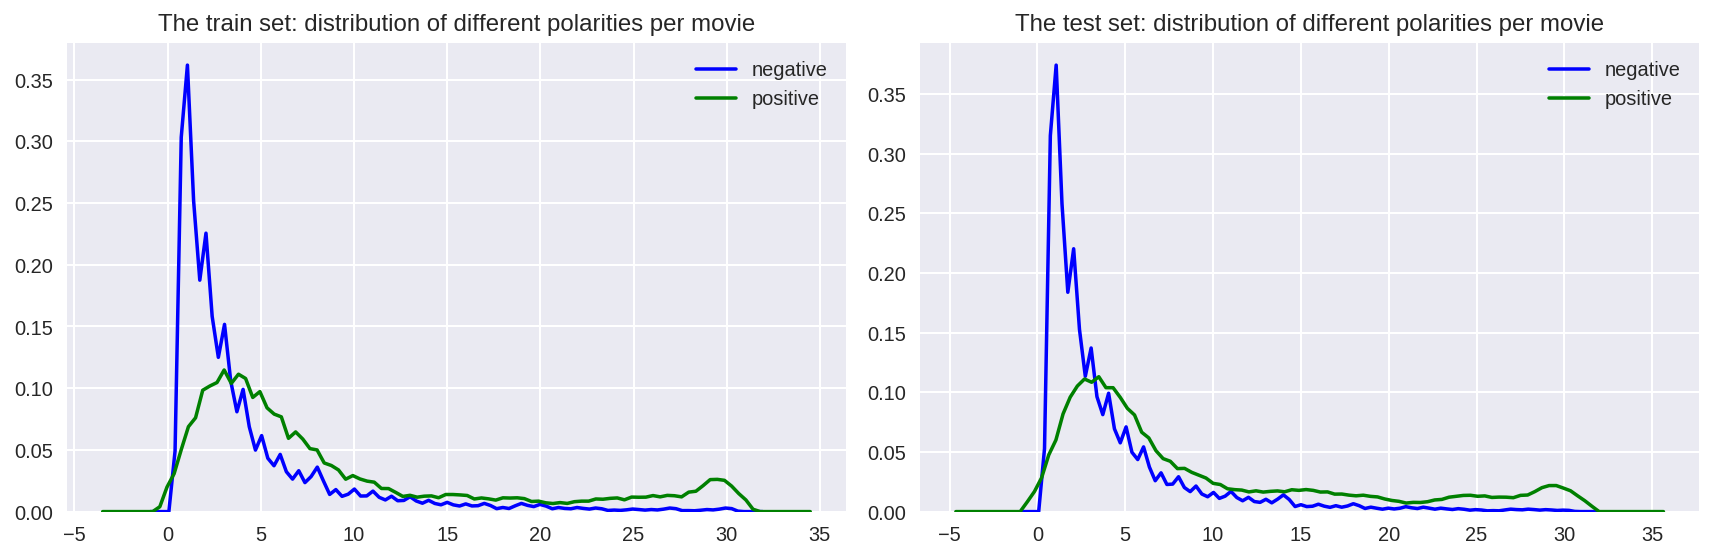

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]

train_pol = train.groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(train_pol[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(train_pol[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1]

test_pol = test.groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(test_pol[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(test_pol[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

- There is similar polarity between the review sentiment in both the train and test sets

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [14]:
import re

def clear_text(text):
    t = re.sub(r"[^a-zA-Z']", " ", text)
    clean = " ".join(t.split())
    return clean

In [15]:
df['review_norm'] = [clear_text(x) for x in df['review'].str.lower()]

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [16]:
train = df[df['ds_part'] == 'train'].copy()
test = df[df['ds_part'] == 'test'].copy()

train_text = train['review_norm']
test_text = test['review_norm']

train_targ = train['pos']
test_targ = test['pos']

print(train_text.shape)
print(test_text.shape)
print(train_targ.shape)
print(test_targ.shape)

(23796,)
(23533,)
(23796,)
(23533,)


## Model 0 - Constant

In [17]:
from sklearn.dummy import DummyClassifier

In [18]:
dum = DummyClassifier(random_state=1)
dum.fit(train_text, train_targ)

DummyClassifier(constant=None, random_state=1, strategy='stratified')

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


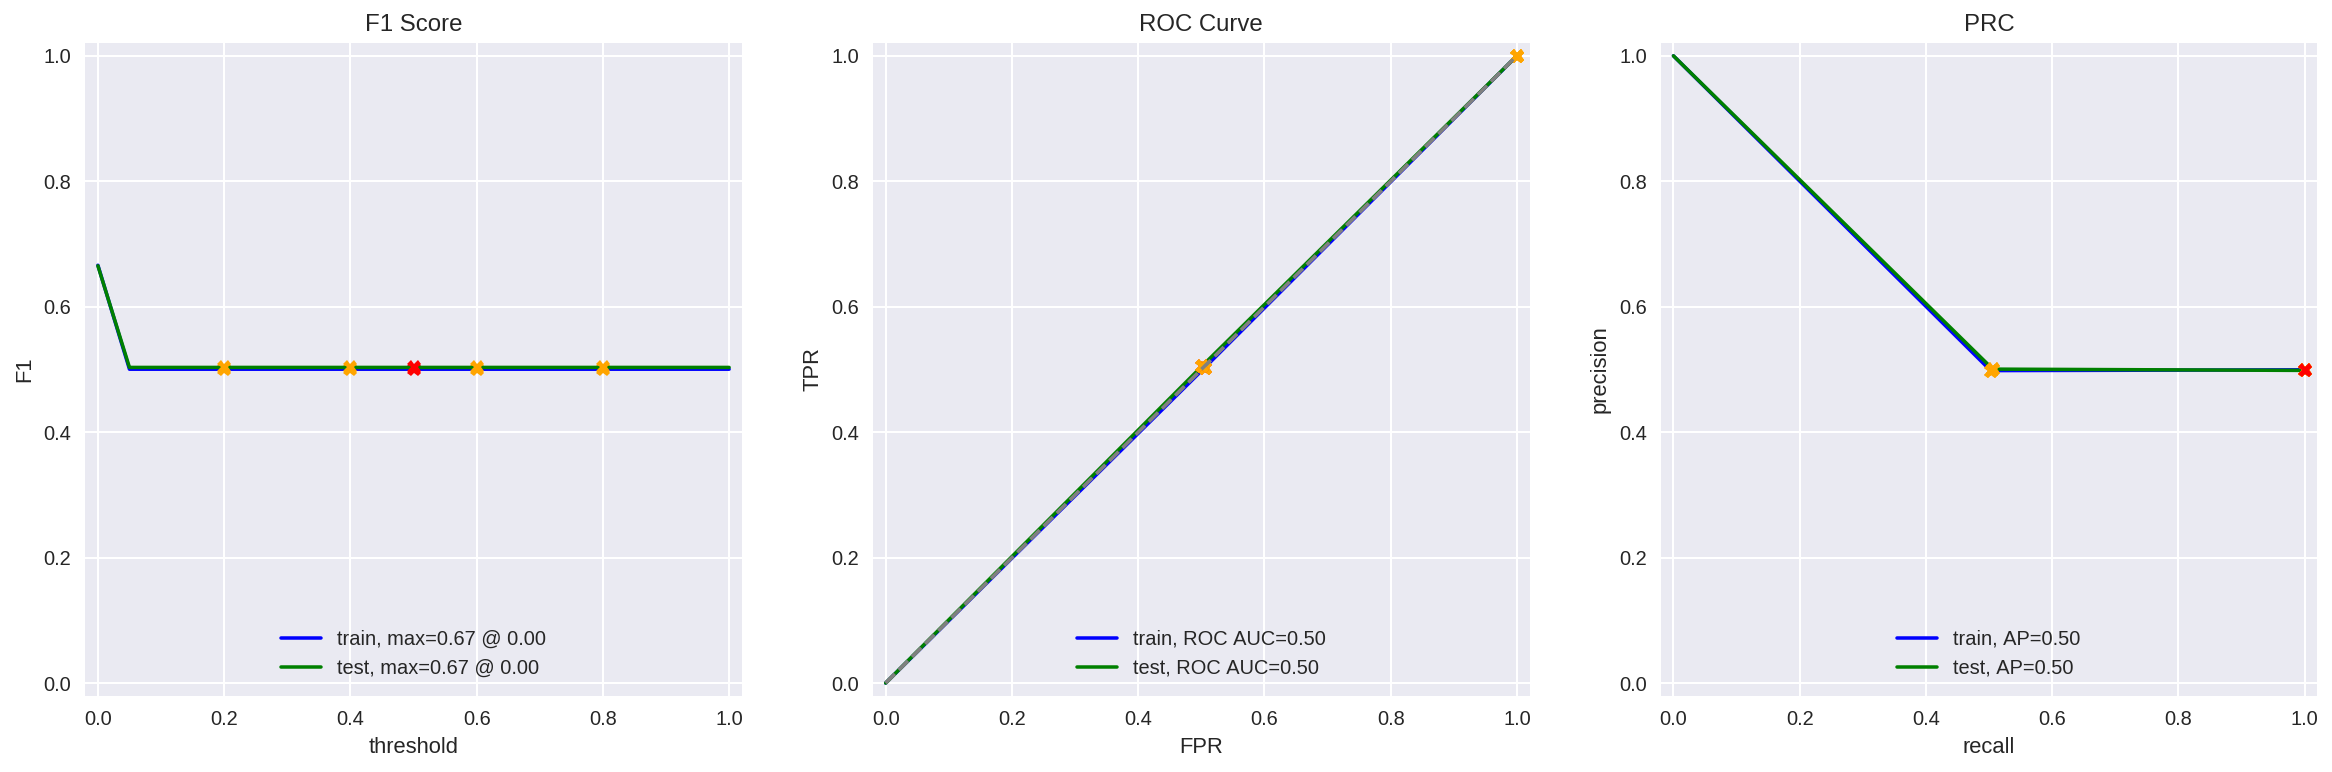

In [19]:
dum_eval = evaluate_model(dum, train_text, train_targ, test_text, test_targ)
dum_eval

- We can see from the Constant classifier that all scores end up as 0.5 as would be expected

## Model 1 - NLTK, TF-IDF and LR

### TF-IDF

In [20]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [21]:
stop_words = set(stopwords.words('english'))
vec = TfidfVectorizer(stop_words=stop_words)
    
def tfidf_preprocessing(train_feature_text, test_feature_text):
    train_tfidf = vec.fit_transform(train_feature_text)
    test_tfidf = vec.transform(test_feature_text)
    
    return train_tfidf, test_tfidf

train_tfidf, test_tfidf = tfidf_preprocessing(train_text, test_text)

print(train_tfidf.shape)
print(test_tfidf.shape)

(23796, 71531)
(23533, 71531)


In [22]:
logreg = LogisticRegression(solver='liblinear', random_state=1)
logreg.fit(train_tfidf, train_targ)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


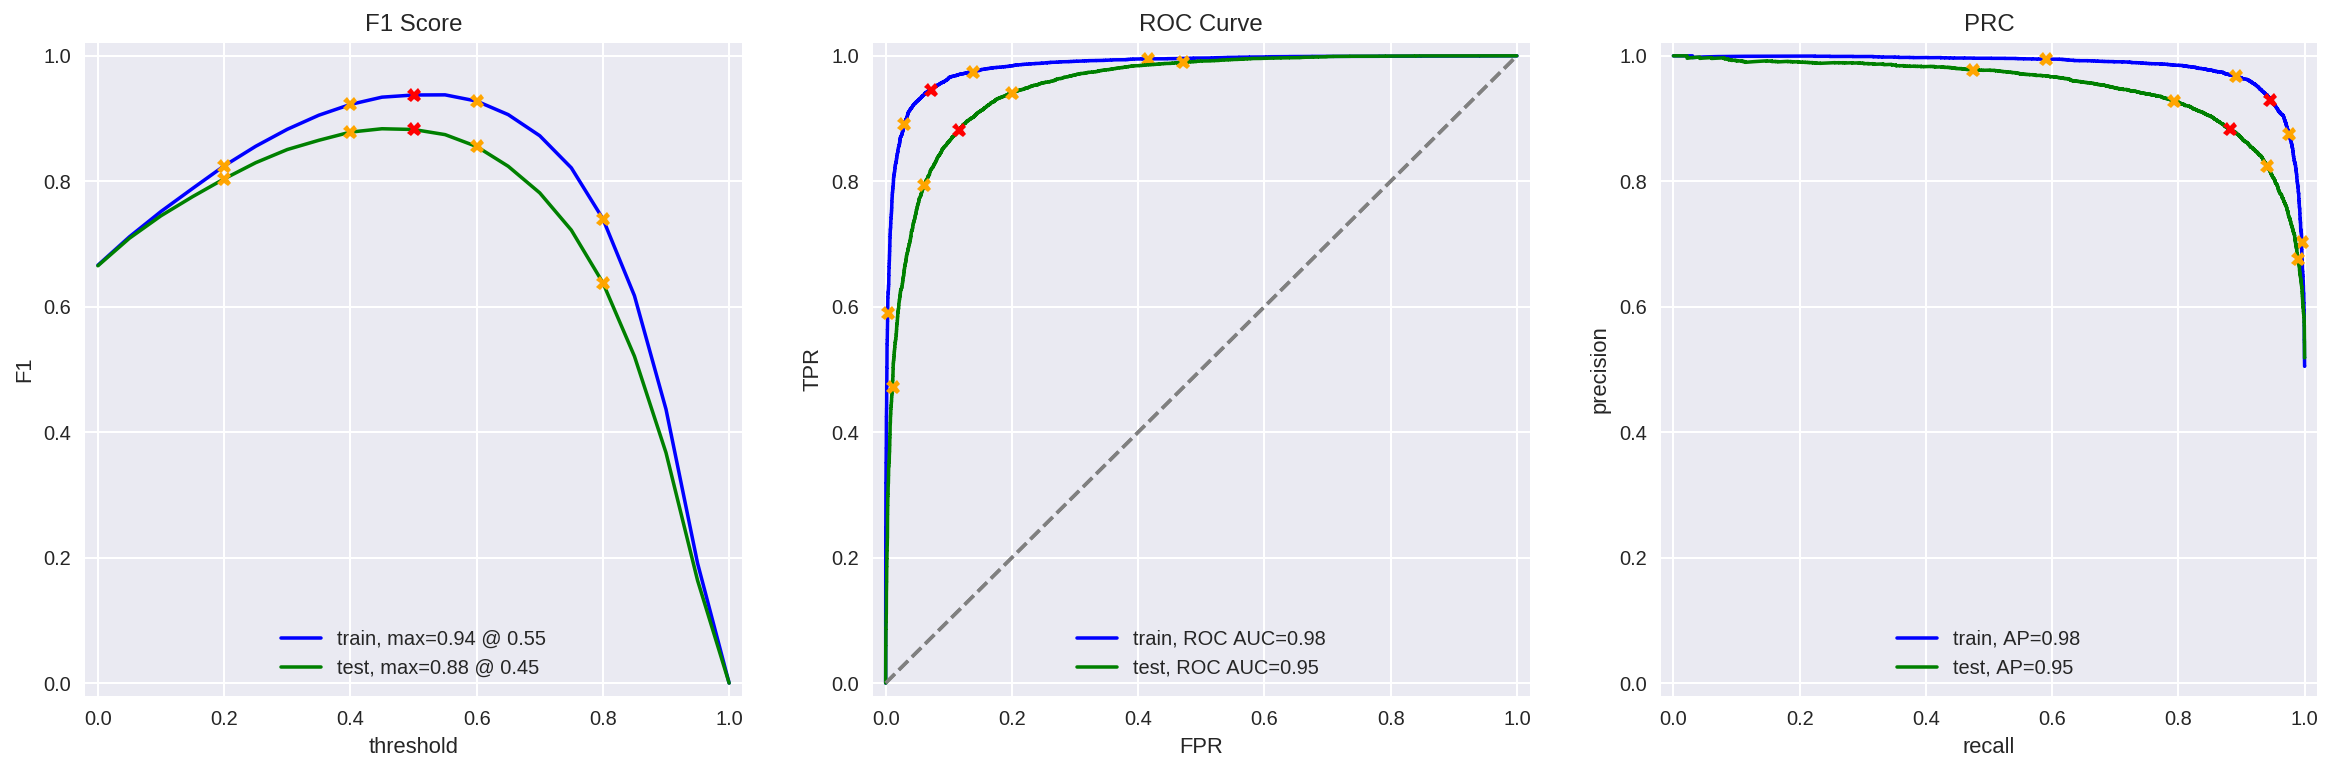

In [23]:
logreg_eval = evaluate_model(logreg, train_tfidf, train_targ, test_tfidf, test_targ)
logreg_eval

## Model 2 - spaCy, TF-IDF and LR

In [24]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [25]:
train_text = train_text.reset_index(drop=True)
train_text

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        this true story of carlson's raiders is more o...
3        should have been titled 'balderdash ' little i...
4        the movie 'gung ho ' the story of carlson's ma...
                               ...                        
23791    o my gosh just give me a minute to breath this...
23792    i can't tell you all how much i love this movi...
23793    legend of zu is possibly the most exciting mov...
23794    this movie is well done on so many levels that...
23795    as a history nut who is particularly intereste...
Name: review_norm, Length: 23796, dtype: object

In [26]:
train_text_list = list(train_text)

In [27]:
def spacy_lemma(series_text):
    
    new_series = []
    for row in list(series_text.index):
        doc = nlp(series_text.loc[row])
        #tokens = [token.lemma_ for token in doc if not token.is_stop]
        tokens = [token.lemma_ for token in doc]
    
        text = ' '.join(tokens)
        new_series.append(text)
    return pd.Series(new_series)

train_text_s = spacy_lemma(train_text)
test_text_s = spacy_lemma(test_text)

print('after spacy')
print(train_text_s.shape)
print(test_text_s.shape)

train_text_ts, test_text_ts = tfidf_preprocessing(train_text_s, test_text_s)

print('---')
print('after tfidf')
print(train_text_ts.shape)
print(test_text_ts.shape)

after spacy
(23796,)
(23533,)
---
after tfidf
(23796, 60376)
(23533, 60376)


In [28]:
logreg2 = LogisticRegression(solver='liblinear', random_state=2)
logreg2.fit(train_text_ts, train_targ)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


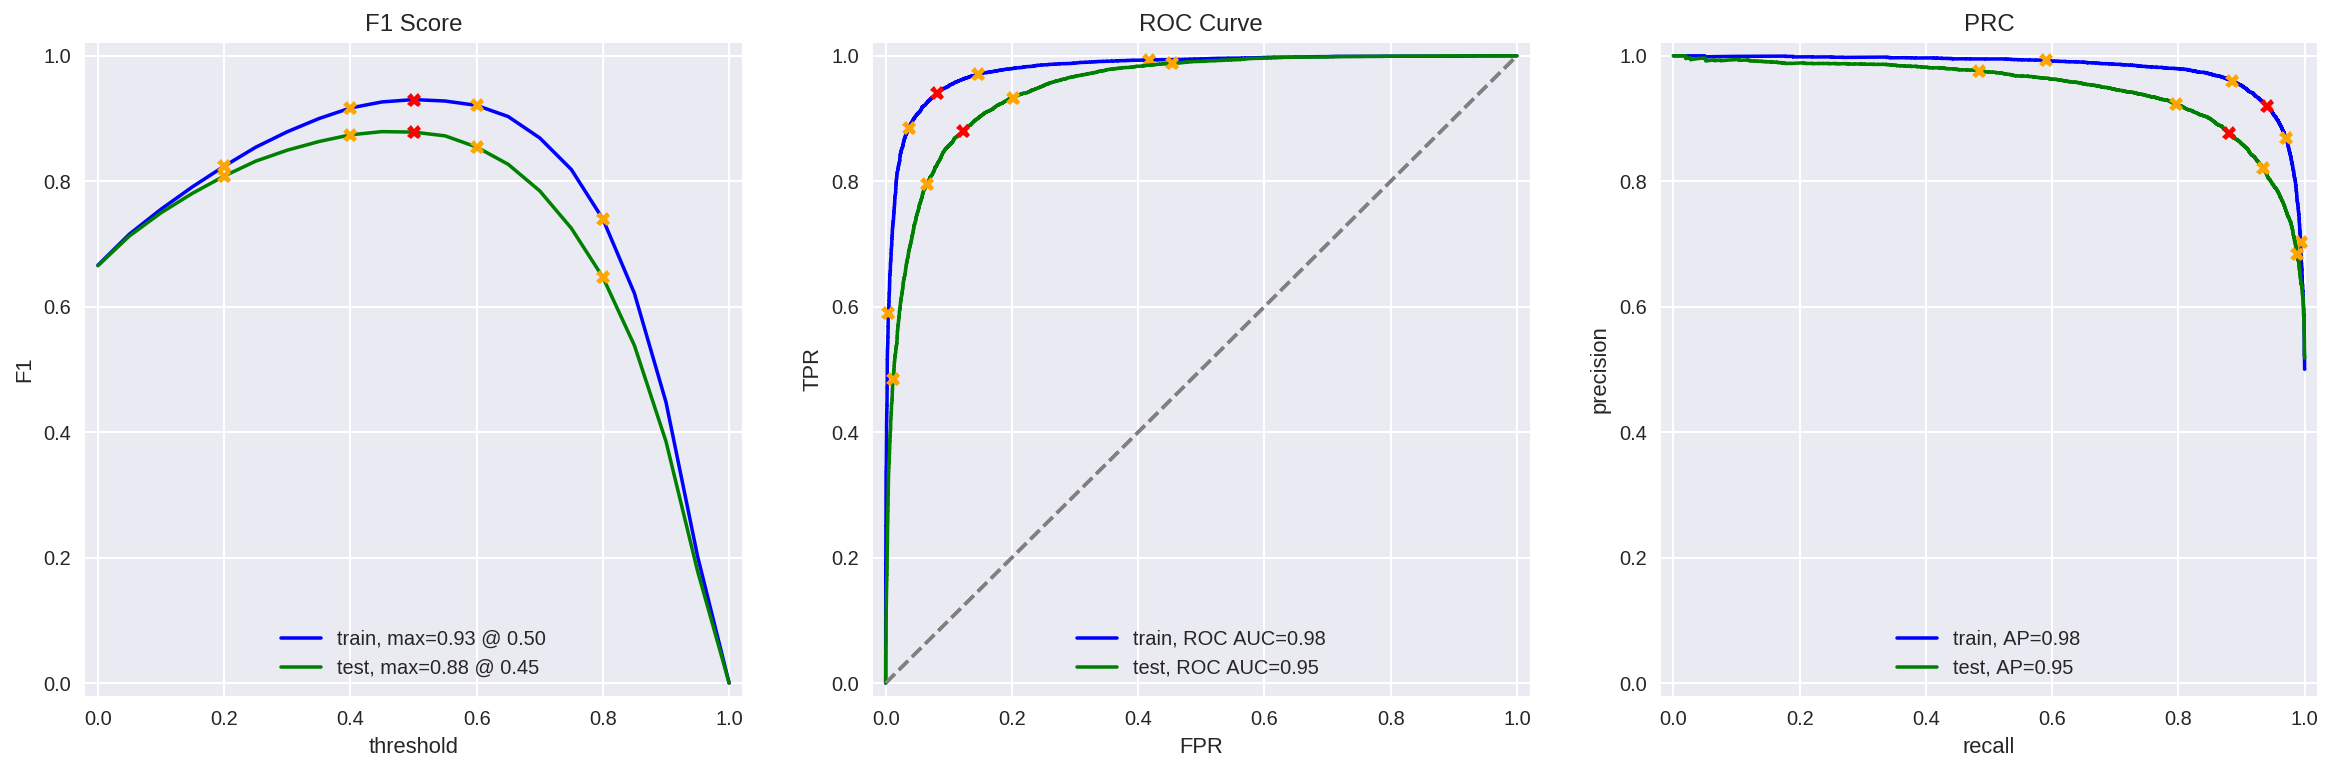

In [29]:
logreg2_eval = evaluate_model(logreg2, train_text_ts, train_targ, test_text_ts, test_targ)
logreg2_eval

## Model 3 - spaCy, TF-IDF and LGBMClassifier

In [30]:
from lightgbm import LGBMClassifier

In [31]:
from sklearn.model_selection import train_test_split

# splitting the train set for 20% validation to tune parameters max_depth & num_leaves

train_ts, val_ts, ytrain, yval = train_test_split(train_text_ts, train_targ, test_size=0.2, random_state=1)

print(train_ts.shape)
print(val_ts.shape)
print(ytrain.shape)
print(yval.shape)

(19036, 60376)
(4760, 60376)
(19036,)
(4760,)


In [32]:
# tuning max_depth
for i in range(25, 36, 5):
    lg = LGBMClassifier(max_depth=i, random_state=1)
    lg.fit(train_ts, ytrain)
    lgp = lg.predict(val_ts)
    print('Depth:', i, 'F1:', metrics.f1_score(yval, lgp))

Depth: 25 F1: 0.8555486670799751
Depth: 30 F1: 0.8532281503010173
Depth: 35 F1: 0.8532281503010173


In [33]:
# tuning num_leaves
for i in range(40, 61, 10):
    lg = LGBMClassifier(max_depth=30, num_leaves=i, random_state=1)
    lg.fit(train_ts, ytrain)
    lgp = lg.predict(val_ts)
    print('Leaves:', i, 'F1:', metrics.f1_score(yval, lgp))

Leaves: 40 F1: 0.8532110091743118
Leaves: 50 F1: 0.8550603915035403
Leaves: 60 F1: 0.8576179588443151


In [34]:
lgbm = LGBMClassifier(max_depth=30, num_leaves=50, random_state=1)
lgbm.fit(train_text_ts, train_targ)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=30,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=50, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.94  0.86
F1         0.94  0.86
APS        0.99  0.93
ROC AUC    0.99  0.94


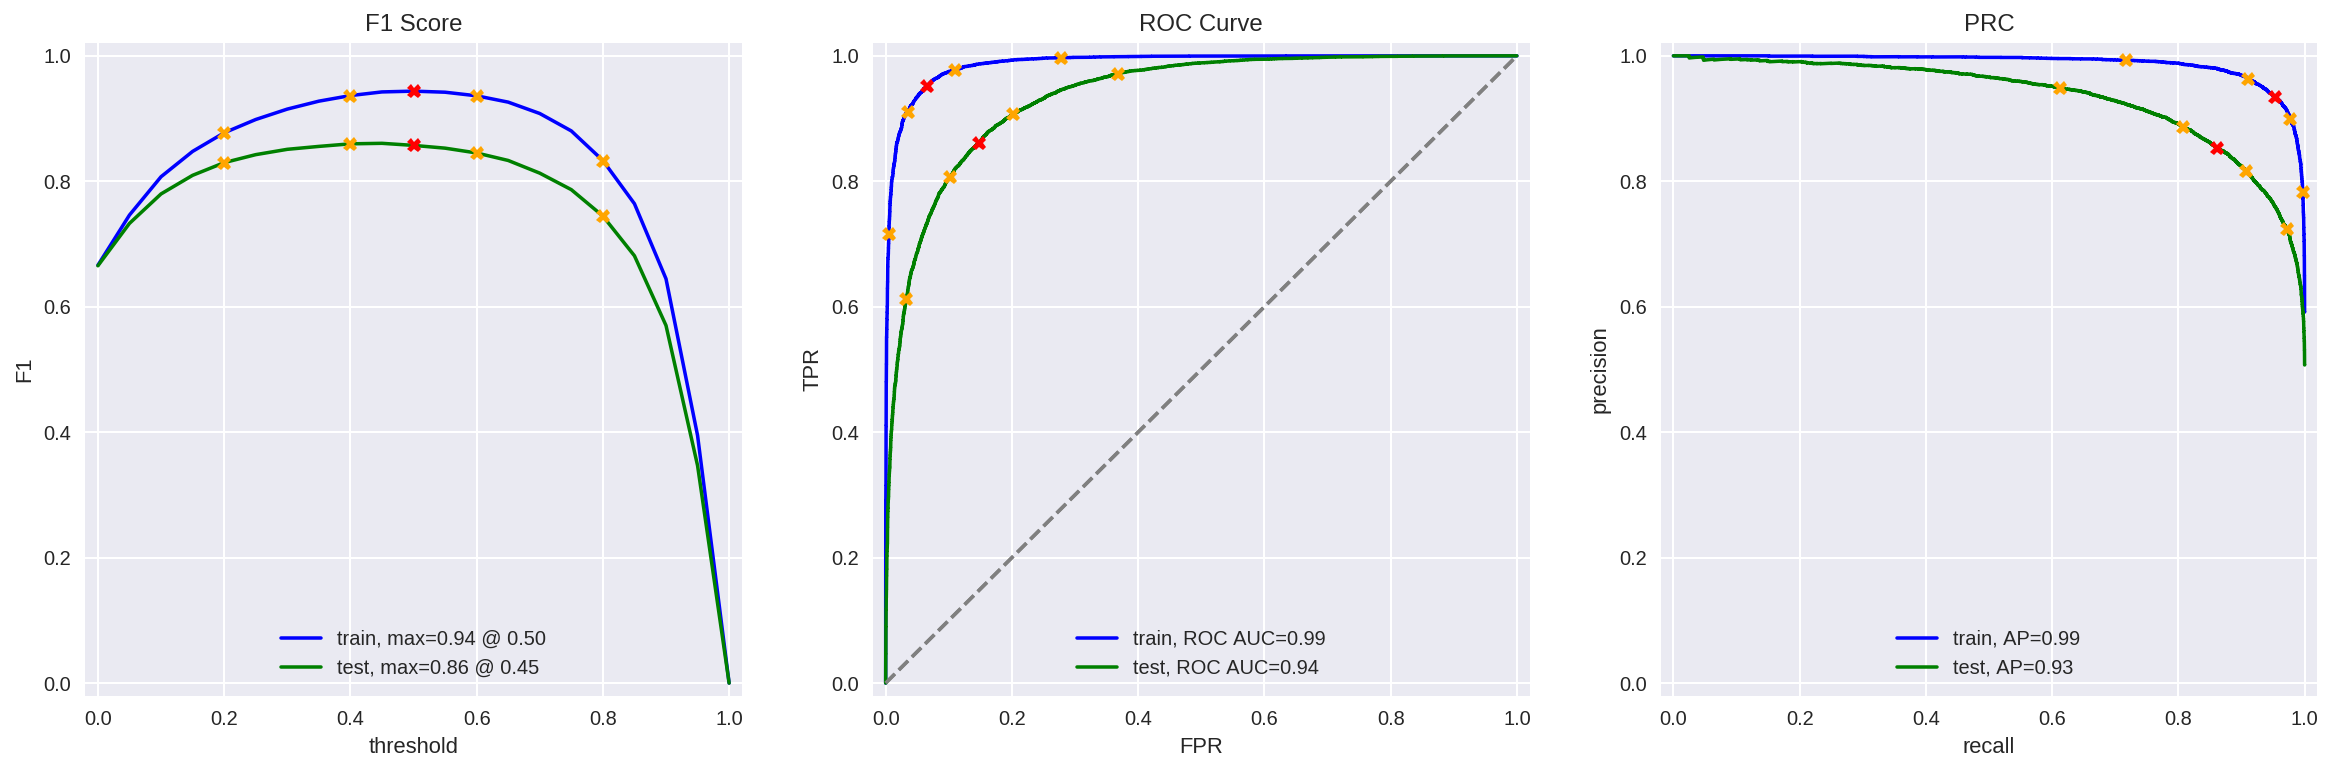

In [35]:
lgbm_eval = evaluate_model(lgbm, train_text_ts, train_targ, test_text_ts, test_targ)
lgbm_eval

## My Reviews

In [44]:
my_rev = pd.DataFrame([
    'This movie made me want to cry, not in a good way.',
    'I was so shocked by the surprise at the end. What a way to finish a movie!',
    'I love this director, she can do no wrong',    
    'This is a sad excuse for film.',
    'This is an incredible installation for the series which now has a very bright future',
    'It was fine',
    'Yawn.',
    'I am so sad that it is over. I wish there could be one more!'
], columns=['review'])

my_rev['review_norm'] = [clear_text(x) for x in my_rev['review'].str.lower()]
my_rev['my_label'] = pd.Series([0, 1, 1, 0, 1, 0, 0, 1])

print(my_rev['review_norm'])

0     this movie made me want to cry not in a good way
1    i was so shocked by the surprise at the end wh...
2             i love this director she can do no wrong
3                        this is a sad excuse for film
4    this is an incredible installation for the ser...
5                                          it was fine
6                                                 yawn
7    i am so sad that it is over i wish there could...
Name: review_norm, dtype: object


## Model 1

In [45]:
texts = my_rev['review_norm']

t1, t2 = tfidf_preprocessing(train_text, texts)
    
print(t1.shape)
print(t2.shape)

(23796, 71531)
(8, 71531)


In [46]:
my_pred = logreg.predict_proba(t2)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_pred[i]:.2f}:  {review}')

0.70:  this movie made me want to cry not in a good way
0.67:  i was so shocked by the surprise at the end what a way to finish a movie
0.42:  i love this director she can do no wrong
0.16:  this is a sad excuse for film
0.80:  this is an incredible installation for the series which now has a very bright future
0.78:  it was fine
0.24:  yawn
0.25:  i am so sad that it is over i wish there could be one more


## Model 2

In [47]:
texts = my_rev['review_norm']

m2_lemm = spacy_lemma(texts)
train, m2_tf_lemm = tfidf_preprocessing(train_text_s, m2_lemm)
my_pred_2 = logreg2.predict_proba(m2_tf_lemm)[:,1]
#print(m2_lemm)
#print(m2_tf_lemm)
#print(my_pred_2)
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_pred_2[i]:.2f}:  {review}')

0.80:  this movie made me want to cry not in a good way
0.66:  i was so shocked by the surprise at the end what a way to finish a movie
0.54:  i love this director she can do no wrong
0.14:  this is a sad excuse for film
0.81:  this is an incredible installation for the series which now has a very bright future
0.90:  it was fine
0.21:  yawn
0.18:  i am so sad that it is over i wish there could be one more


## Model 3

In [48]:
texts = my_rev['review_norm']

my_pred_3 = lgbm.predict_proba(m2_tf_lemm)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_pred_3[i]:.2f}:  {review}')

0.76:  this movie made me want to cry not in a good way
0.65:  i was so shocked by the surprise at the end what a way to finish a movie
0.79:  i love this director she can do no wrong
0.56:  this is a sad excuse for film
0.87:  this is an incredible installation for the series which now has a very bright future
0.77:  it was fine
0.50:  yawn
0.48:  i am so sad that it is over i wish there could be one more


# Conclusions

- When testing my models, the two logistic regression models performed better than the LGBM model.
    - Each logistic regression had a 0.88 F1 score on the test set while LGBM only scored 0.86
    - The first model encoded using only TF-IDF, while the second used both TF-IDF and spaCy
    - Both Logistic Regression models had identical score statistics on the test data

**Looking at my manually entered reviews:**
- I created a list to hold what I would say are the positivity scores in a binary fashion (1=pos, 0=neg)
- Below I scored each model on the 8 entries manually

In [49]:
man_scores = pd.DataFrame({
    'text':my_rev['review'],
    'pos':my_rev['my_label'],
    'LogReg1':np.round(my_pred),
    'LogReg2':np.round(my_pred_2),
    'LGBM':np.round(my_pred_3)
})

#man_scores['lr1_true'] = [man_scores['pos'] == man_scores['LogReg1']]
man_scores

,text,pos,LogReg1,LogReg2,LGBM
0,"This movie made me want to cry, not in a good ...",0,1.0,1.0,1.0
1,I was so shocked by the surprise at the end. W...,1,1.0,1.0,1.0
2,"I love this director, she can do no wrong",1,0.0,1.0,1.0
3,This is a sad excuse for film.,0,0.0,0.0,1.0
4,This is an incredible installation for the ser...,1,1.0,1.0,1.0
5,It was fine,0,1.0,1.0,1.0
6,Yawn.,0,0.0,0.0,0.0
7,I am so sad that it is over. I wish there coul...,1,0.0,0.0,0.0


In [50]:
print('LogReg1 # Correct:', (man_scores['pos'] == man_scores['LogReg1']).sum())
print('LogReg2 # Correct:', (man_scores['pos'] == man_scores['LogReg2']).sum())
print('LGBM # Correct:', (man_scores['pos'] == man_scores['LGBM']).sum())

LogReg1 # Correct: 4
LogReg2 # Correct: 5
LGBM # Correct: 4


- In my 8 manual cases:
    - The second Logistic Regression model classified 5 correctly while the first model and the LGBM predicted 4 correctly
    - Since these models are regressors, I assumed a 0.5 threshold and rounded up or down based on model output

NOTE: I began to run BERT for encoding, but there was an issue with it running on my CPU so I opted out according to the directions